In [1]:
import cartopy.crs as ccrs
import csv
from dataclasses import asdict
from datetime import datetime, timedelta
import easygems.healpix as egh
#from importlib import reload
import intake
import matplotlib.pyplot as plt
import numpy as np
import orcestra
import orcestra.flightplan as fp
import orcestra.sat
from orcestra.flightplan import LatLon, IntoCircle, bco, sal
import pandas as pd


In [2]:
# Function that finds longitude of ec track that corresponds to the provided latitude

def find_ec_lon(lat_sel, ec_lons, ec_lats):
    return ec_lons[np.argmin(np.abs(ec_lats-lat_sel))]

In [3]:
# Define dates for forecast initialization and flight

issued_time = datetime(2024, 8, 5, 12, 0, 0)
issued_time_str = issued_time.strftime('%Y-%m-%d')

flight_time = datetime(2024, 8, 13, 12, 0, 0)
flight_time_str = flight_time.strftime('%Y-%m-%d')
flight_index = f"HALO-{flight_time.strftime('%Y%m%d')}a"

print("Initalization date of IFS forecast: " + issued_time_str + "\nFlight date: " + flight_time_str + "\nFlight index: " + flight_index)

Initalization date of IFS forecast: 2024-08-05
Flight date: 2024-08-13
Flight index: HALO-20240813a


In [4]:
# Domain definition
# TO DO: replace by global definition once it exists
lon_min, lon_max, lat_min, lat_max = -65, -5, -10, 25

In [5]:
# Load forecast data
cat = intake.open_catalog("https://tcodata.mpimet.mpg.de/internal.yaml")
ds = cat.HIFS(refdate=issued_time_str, reftime=issued_time.hour).to_dask().pipe(egh.attach_coords)

/usr/local/Caskroom/miniforge/base/envs/wblib/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


In [6]:
# Load ec satellite track for 
track = orcestra.sat.SattrackLoader("EARTHCARE", "2024-08-05").get_track_for_day(flight_time_str)
track = track.sel(time=slice(flight_time_str + " 06:00", None))
ec_lons, ec_lats = track.lon.values, track.lat.values

**Waypoint definitions**

In [7]:
# Mass flux circle radius (m)
radius = 100e3

In [8]:
# ITCZ edges visually estimated from iwv contours

lat_edge_south = 8.5
lat_edge_north = 14.0

In [9]:
# ?
band = "east"

airport = sal if band == "east" else bco

# Point where we enter ec track? visually estimated? Rename to "lat_track_entry_north"?
lat_north = 15.5 # 10th percentile 
lat_south = 5.0 # 5th percentile - 1°

In [10]:
# Setting lat/lon coordinates

# Points where we get on ec track?
north = LatLon(lat_north, find_ec_lon(lat_north, ec_lons, ec_lats), "north")
south = LatLon(lat_south, find_ec_lon(lat_south, ec_lons, ec_lats), "south")

# Intersection of ITCZ edges with ec track
edge_north = LatLon(lat_edge_north, find_ec_lon(lat_edge_north, ec_lons, ec_lats), "edge_north")
edge_south = LatLon(lat_edge_south, find_ec_lon(lat_edge_south, ec_lons, ec_lats), "edge_south")

# Center of middle circle
center = edge_south.towards(edge_north).assign_label("center")

# Southern return point
returnPoint = north if band == "east" else LatLon(bco.lat, -53.0, "")


# What does leg refer to?
leg_south = [
     airport,
     north,
     south
]

leg_circles = [
     IntoCircle(edge_south, radius, 360),
     IntoCircle(center, radius, 360),
     IntoCircle(edge_north, radius, 360),
]
    
leg_home = [
     north,
     airport
]

waypoints = leg_south + leg_circles + leg_home 

path = fp.expand_path(waypoints, dx=10e3)

#print(f"duration: {halo_flight_duration(path)}")

/usr/local/Caskroom/miniforge/base/envs/wblib/lib/python3.12/site-packages/textalloc/__init__.py:466: UserWarning: Usage of allocate_text will be replaced with allocate in future releases, removing the need for the fig argument
  warnings.warn(


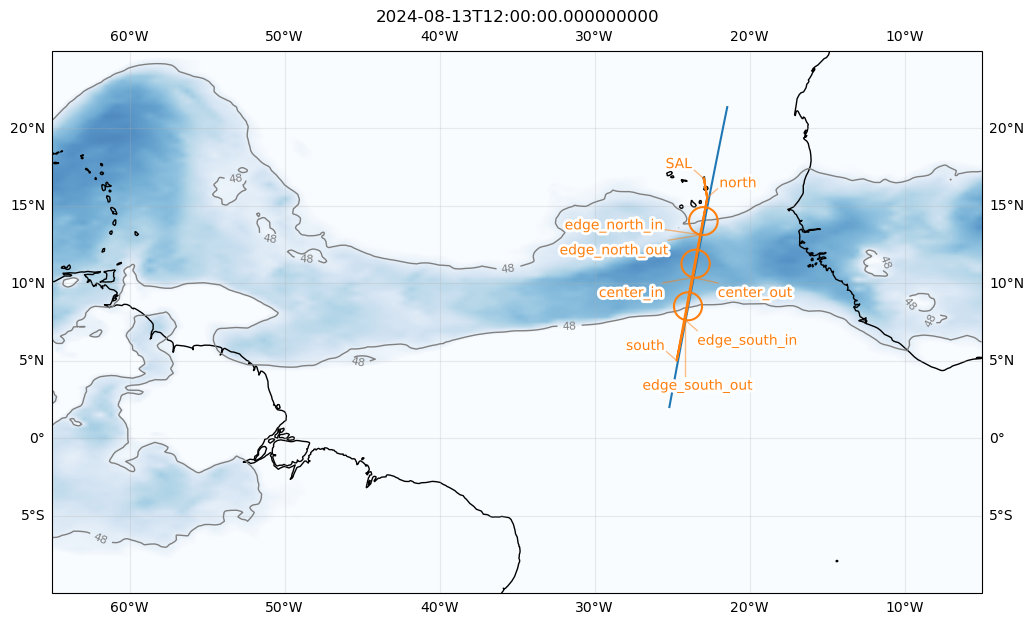

In [11]:
plt.figure(figsize = (12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines(alpha=1.0)
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha = 0.25)


cwv_flight_time = ds["tcwv"].sel(time=flight_time, method = "nearest")
fp.plot_cwv(cwv_flight_time, levels = [48.0])
plt.title(cwv_flight_time.time.values)

plt.plot(ec_lons, ec_lats)
fp.plot_path(path, ax, color="C1")

In [12]:
pd.DataFrame.from_records(map(asdict, [north, edge_north, center, edge_south, south])).set_index("label")

,lat,lon
label,,
north,15.500000,-22.731800
edge_north,14.000000,-22.983100
center,11.250664,-23.482294
edge_south,8.500000,-23.972100
south,5.000000,-24.702000


In [13]:
find_ec_lon(1.5, ec_lons, ec_lats)

np.float64(-25.1742)

In [14]:
lats, lons, labels = [], [], []

for point in waypoints:
    
    if isinstance(point, IntoCircle):
        point = point.center
        
    lats.append(point.lat)
    lons.append(point.lon)
    labels.append(point.label)
    

In [15]:


# The name of your output file
flight_name = f"flight_data_{flight_index}.csv"

# Open a file in write mode
with open(flight_name, mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=';')

    # Write the header
    writer.writerow([flight_index])
    writer.writerow(["Index", "Location", "Lat (+-90)", "Lon (+-180)", "Comments"])

    # Write the data rows
    for index, (lat, lon, label) in enumerate(zip(lats, lons, labels)):
        writer.writerow([index, "", lat, lon, label])

print(f"CSV file '{flight_name}' created successfully.")

CSV file 'flight_data_HALO-20240813a.csv' created successfully.
